#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##[TO COMPLETE] Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [4]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [5]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [6]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [7]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [8]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [9]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###[TO COMPLETE] Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

[TO COMPLETE] In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

**ANSWER**

The problem we have is a binary classification problem which has target values 0 and 1, therefore using sigmoid would be a best choice of an activation function since it will have an output from 0 to 1.

While compling the model, I have chosen the binary cross entropy loss because we are going to make a binary classification, which the loss will be calculated for only two target values.

In [42]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [43]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                1376      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [44]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 29s 141ms/step - loss: 0.6755 - accuracy: 0.5722 - val_loss: 0.6216 - val_accuracy: 0.6853
Epoch 2/10
196/196 [==============================] - 28s 142ms/step - loss: 0.4340 - accuracy: 0.8078 - val_loss: 0.3937 - val_accuracy: 0.8347
Epoch 3/10
196/196 [==============================] - 28s 141ms/step - loss: 0.2861 - accuracy: 0.8856 - val_loss: 0.4237 - val_accuracy: 0.8051
Epoch 4/10
196/196 [==============================] - 28s 141ms/step - loss: 0.2177 - accuracy: 0.9180 - val_loss: 0.3705 - val_accuracy: 0.8472
Epoch 5/10
196/196 [==============================] - 28s 141ms/step - loss: 0.1660 - accuracy: 0.9416 - val_loss: 0.3870 - val_accuracy: 0.8460
Epoch 6/10
196/196 [==============================] - 28s 142ms/step - loss: 0.1632 - accuracy: 0.9401 - val_loss: 0.4224 - val_accuracy: 0.8430
Epoch 7/10
196/196 [==============================] - 28s 142ms/step - loss: 0.0931 - accuracy: 0.9707 - val_loss: 0.4501 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

In [10]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

391/391 - 8s - loss: 0.4683 - accuracy: 0.8379
accuracy: 83.79%


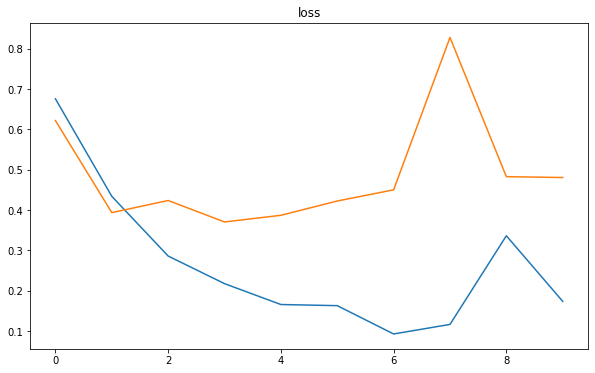

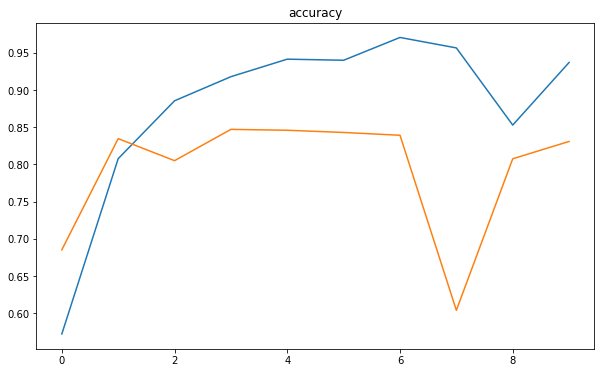

In [46]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion immediately after this cell*

**Answer:**
The total parameters SimpleRNN has is 101,409 where with LSTM model I have developed it is 101,415 and for GRU model I have used below it is 101,497 in order to have a fair comprasion. In order to obtain these results, I have used 14 units in LSTM and 17 units in GRU

**LSTM**

In [47]:
#LSTM model
lstm=keras.models.Sequential()
lstm.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
lstm.add(keras.layers.LSTM(14)) 
lstm.add(keras.layers.Dense(1, activation="sigmoid"))

lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

lstm.summary()



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 14)                1400      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 47s 233ms/step - loss: 0.5822 - accuracy: 0.6979 - val_loss: 0.4276 - val_accuracy: 0.8214
Epoch 2/10
196/196 [==============================] - 46s 233ms/step - loss: 0.3317 - accuracy: 0.8670 - val_loss: 0.3123 - val_accuracy: 0.8723
Epoch 3/10
196/196 [==============================] - 46s 235ms/step - loss: 0.2247 - accuracy: 0.9172 - val_loss: 0.3018 - val_accuracy: 0.8728
Epoch 4/10
196/196 [==============================] - 46s 232ms/step - loss: 0.1749 - accuracy: 0.9373 - val_loss: 0.3047 - val_accuracy: 0.8768
Epoch 5/10
196/196 [==============================] - 46s 232ms/step - loss: 0.1408 - accuracy: 0.9534 - val_loss: 0.3457 - val_accuracy: 0.8702
Epoch 6/10
196/196 [==============================] - 46s 235ms/step - loss: 0.1181 - accuracy: 0.9632 - val_loss: 0.3709 - val_accuracy: 0.8654
Epoch 7/10
196/196 [==============================] - 45s 231ms/step - loss: 0.0967 - accuracy: 0.9702 - val_loss: 0.4096 - val_ac

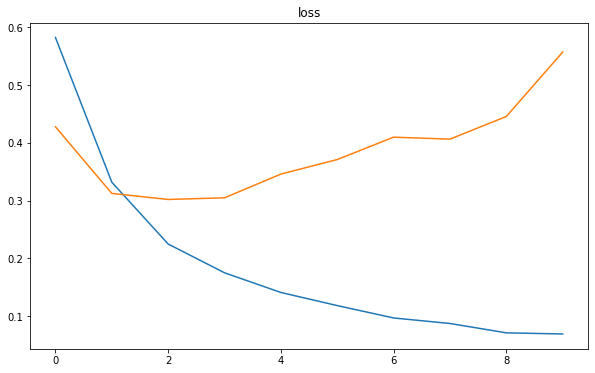

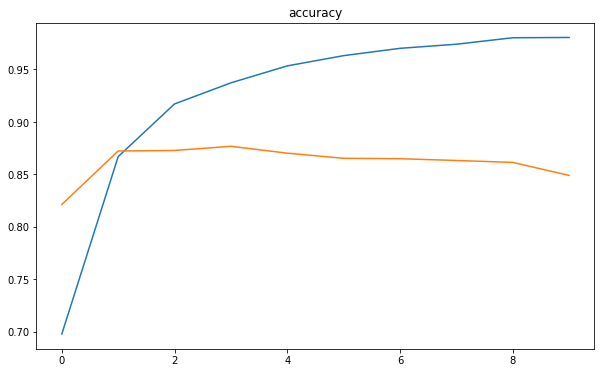

In [48]:
history_lstm = lstm.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history_lstm)
plot_accuracy(history_lstm)

scores = lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (lstm.metrics_names[1], scores[1]*100))


**GRU**

In [49]:
gru_model = keras.models.Sequential()
gru_model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
gru_model.add(keras.layers.GRU(17))
gru_model.add(keras.layers.Dense(1, activation="sigmoid"))
gru_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
gru_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
gru_4 (GRU)                  (None, 17)                1479      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 18        
Total params: 101,497
Trainable params: 101,497
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 48s 235ms/step - loss: 0.5448 - accuracy: 0.7108 - val_loss: 0.3667 - val_accuracy: 0.8424
Epoch 2/10
196/196 [==============================] - 46s 233ms/step - loss: 0.2997 - accuracy: 0.8776 - val_loss: 0.3443 - val_accuracy: 0.8526
Epoch 3/10
196/196 [==============================] - 46s 233ms/step - loss: 0.2342 - accuracy: 0.9102 - val_loss: 0.3565 - val_accuracy: 0.8585
Epoch 4/10
196/196 [==============================] - 45s 232ms/step - loss: 0.1900 - accuracy: 0.9306 - val_loss: 0.3702 - val_accuracy: 0.8581
Epoch 5/10
196/196 [==============================] - 45s 232ms/step - loss: 0.1644 - accuracy: 0.9420 - val_loss: 0.3796 - val_accuracy: 0.8540
Epoch 6/10
196/196 [==============================] - 46s 233ms/step - loss: 0.1370 - accuracy: 0.9544 - val_loss: 0.4119 - val_accuracy: 0.8529
Epoch 7/10
196/196 [==============================] - 46s 233ms/step - loss: 0.1221 - accuracy: 0.9599 - val_loss: 0.4383 - val_ac

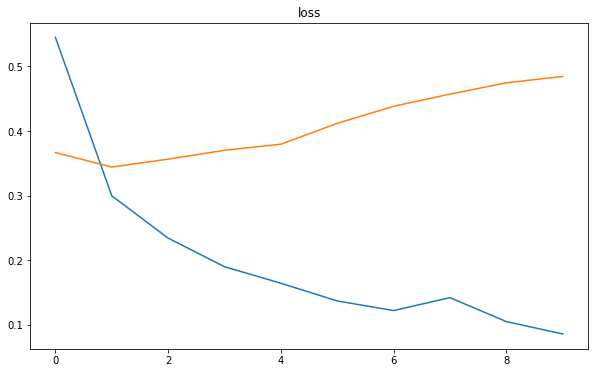

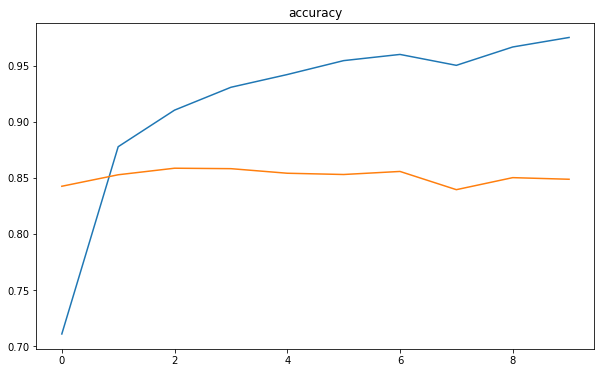

In [50]:
history_gru = gru_model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history_gru )
plot_accuracy(history_gru )

scores = gru_model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (gru_model.metrics_names[1], scores[1]*100))

#**Comparison of Results**

I have already explained the parameter numbers and the number of units I have used in LSTM and GRU in order to have a fair comparison, in the answers section above.
When comparing the performances, 

Simple RNN: loss: 0.4683 - accuracy: 0.8379

LSTM : loss: 0.5343 - accuracy: 0.8566


GRU : loss: 0.4762 - accuracy: 0.8515

As can be seen from the results, GRU and LSTM outperformed compared to SimpleRNN. They both have higher accuracy than SimpleRNN.
But still loss obtained from these two models are too high which can be interpreted as overfitting. 
LSTM with almost same number of parameters compared to others, outperformed and it has the best accuracy, yet it is difficult to say what made this difference on the performance increase between the GRU and LSTM.

When comparing the training time:

Simple RNN: between 27-29 seconds
LSTM: between 45-47 seconds
GRU: between 46 to 48 seconds

As can be seen from the training times, eventhough the accuracy increased in both LSTM and GRU, the time needed for training also increased, which can be explained by the number of operations needed to be done/computed in each step.


##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [51]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 114s 567ms/step - loss: 0.5013 - accuracy: 0.7434 - val_loss: 0.4301 - val_accuracy: 0.8043
Epoch 2/5
196/196 [==============================] - 110s 562ms/step - loss: 0.2888 - accuracy: 0.8858 - val_loss: 0.3914 - val_accuracy: 0.8263
Epoch 3/5
196/196 [==============================] - 110s 560ms/step - loss: 0.2123 - a

391/391 - 19s - loss: 0.3196 - accuracy: 0.8670
accuracy: 86.70%


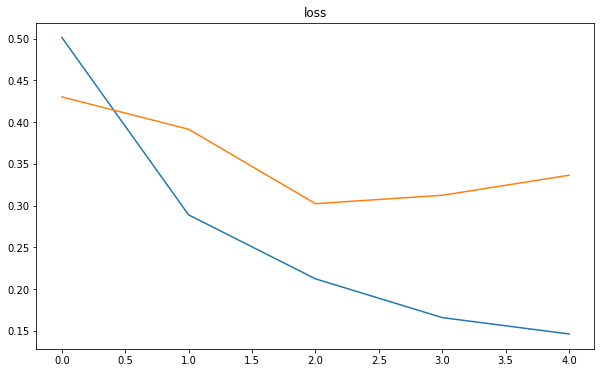

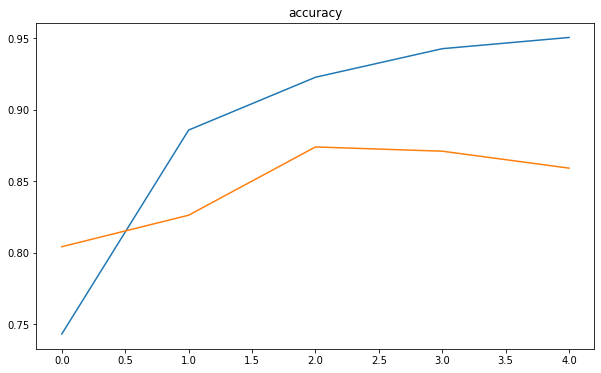

In [52]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**[TO COMPLETE]**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

**Answer:**
I have used different dropout values and the best dropout value I have obrained to reduce overfitting is 0.8, I have applied dropout to both Embedding and bidirectional layers.

**[TO COMPLETE]** Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

In [11]:
model_bidirectional1 = keras.models.Sequential()
model_bidirectional1.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional1.add(keras.layers.Dropout(0.8))
model_bidirectional1.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional1.add(keras.layers.Dropout(0.8))
model_bidirectional1.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
196/196 [==============================] - 19s 55ms/step - loss: 0.6864 - accuracy: 0.5378 - val_loss: 0.5749 - val_accuracy: 0.7134
Epoch 2/5
196/196 [==============================] - 10s 52ms/step - loss: 0.4949 - accuracy: 0.7833 - val_loss: 0.3526 - val_accuracy: 0.8623
Epoch 3/5
196/196 [==============================] - 10s 52ms/step - loss: 0.3856 - accuracy: 0.8485 - val_loss: 0.3653 - val_accuracy: 0.8555
Epoch 4/5
196/196 [==============================] - 10s 52ms/step - loss: 0.3429 - accuracy: 0.8689 - val_loss: 0.2920 - val_accuracy: 0.8790
Epoch 5/5
196/196 [==============================] - 10s 52ms/step - loss: 0.3174 - accuracy: 0.8798 - val_loss: 0.2906 - val_accuracy: 0.8758
391/391 - 6s - loss: 0.2769 - accuracy: 0.8802
accuracy: 88.02%


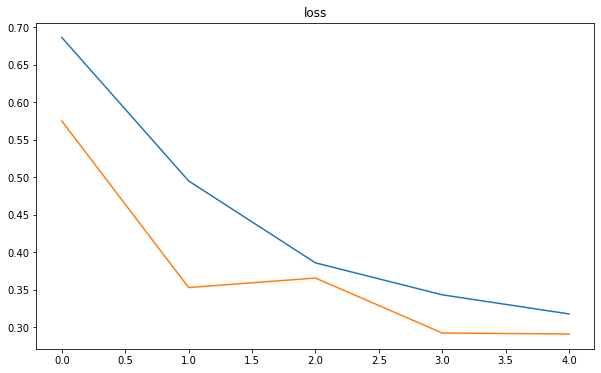

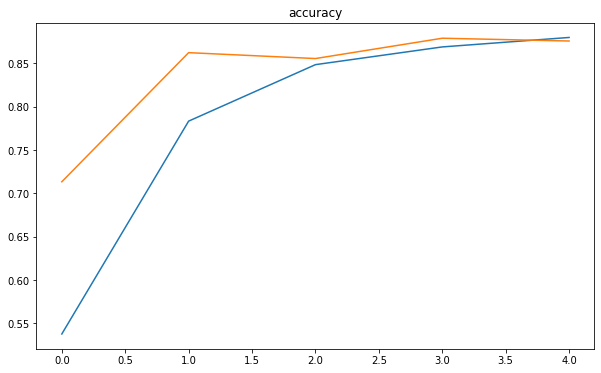

In [12]:
history = model_bidirectional1.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional1.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional1.metrics_names[1], scores[1]*100))

# **Changing some hyper parameters**

I am going to change some hyperparameters which are:
1. Batch size
2. Number of units
3. Epochs

You will see the results and discussions in the following windows, and how these hyperparameters affect the overfitting issue.


Changing the epochs from 5 to 15, the remaining values are the same as bidirectional LSTM, since I wanted to see the effect of increasing epochs

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                11008     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 14s 55ms/step - loss: 0.5408 - accuracy: 0.7294 - val_loss: 0.3704 - val_accuracy: 0.8450
Epoch 2/15
196/196 [==============================] - 10s 52ms/step - loss: 0.2846 - accuracy: 0.8900 - val_loss: 0.2970 - val_accuracy: 0.8770
Epoch 3/15
196/196 [==============================] - 10s 52ms/step - loss: 0.2051 - accu

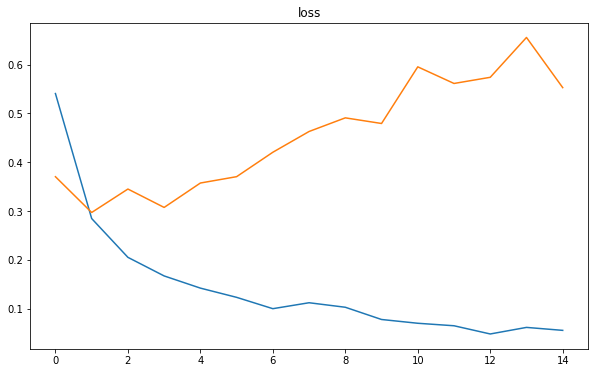

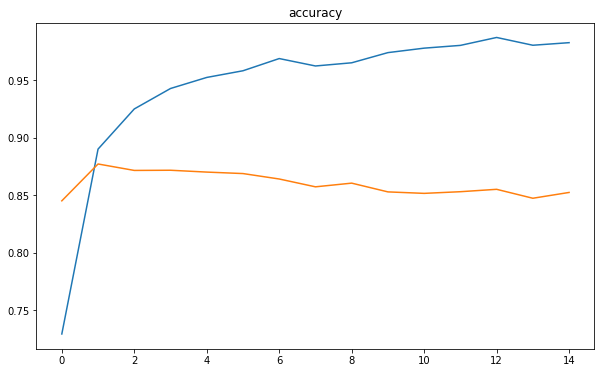

In [20]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                            epochs=15, batch_size=128, validation_data=(X_valid_trim, y_valid))


plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

Changing the batch size from 128 to 256 but the same model is used as bidirectional LSTM

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 64)                11008     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
98/98 [==============================] - 10s 75ms/step - loss: 0.6271 - accuracy: 0.6548 - val_loss: 0.5202 - val_accuracy: 0.7860
Epoch 2/5
98/98 [==============================] - 6s 66ms/step - loss: 0.4552 - accuracy: 0.8120 - val_loss: 0.4180 - val_accuracy: 0.8254
Epoch 3/5
98/98 [==============================] - 6s 66ms/step - loss: 0.3354 - accuracy: 0.874

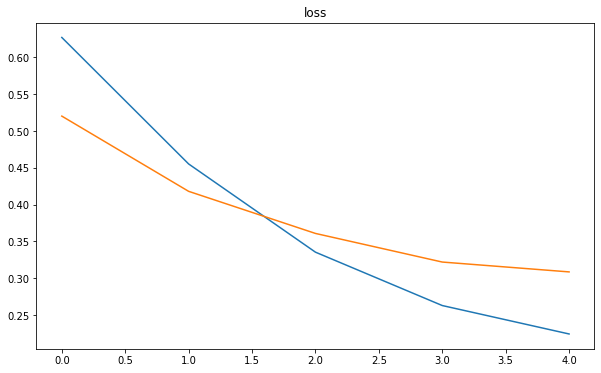

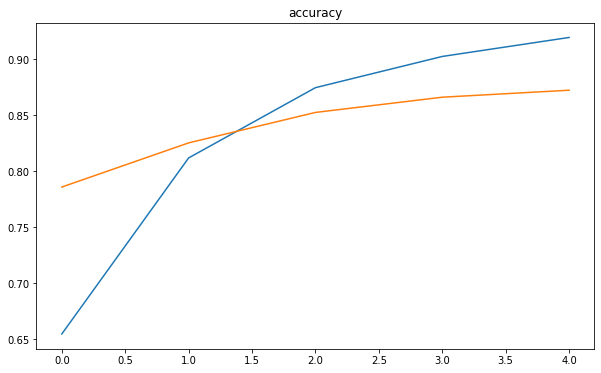

In [21]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                            epochs=5, batch_size=256, validation_data=(X_valid_trim, y_valid))


plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

Changing the number of units to 64 the other things are the same as the bidirectional LSTM


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 128)               38400     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 138,529
Trainable params: 138,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 16s 69ms/step - loss: 0.5157 - accuracy: 0.7502 - val_loss: 0.3465 - val_accuracy: 0.8582
Epoch 2/5
196/196 [==============================] - 12s 63ms/step - loss: 0.2755 - accuracy: 0.8914 - val_loss: 0.3364 - val_accuracy: 0.8702
Epoch 3/5
196/196 [==============================] - 12s 63ms/step - loss: 0.2099 - accurac

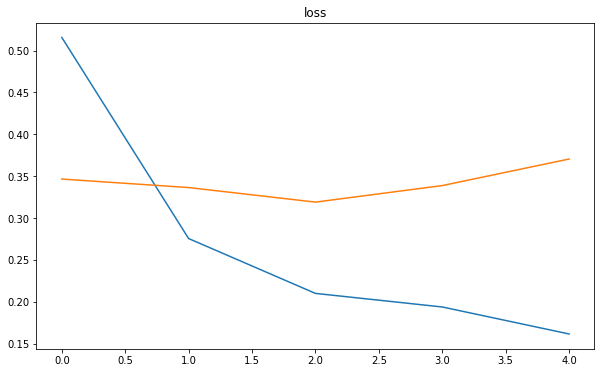

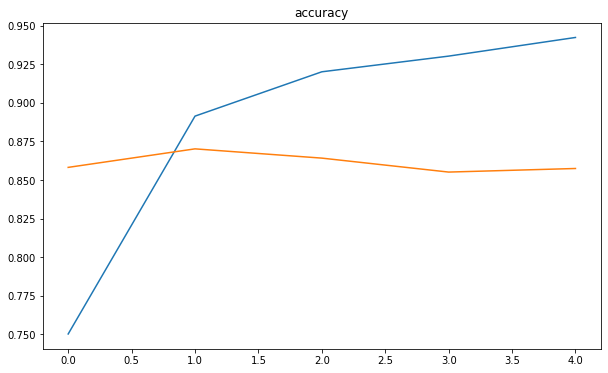

In [23]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                            epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))


plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

Increasing the epochs into 15 in the 64 units LSTM to see the affect

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 128)               38400     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 138,529
Trainable params: 138,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 15s 66ms/step - loss: 0.5680 - accuracy: 0.6866 - val_loss: 0.3844 - val_accuracy: 0.8374
Epoch 2/15
196/196 [==============================] - 13s 65ms/step - loss: 0.3405 - accuracy: 0.8562 - val_loss: 0.4306 - val_accuracy: 0.8127
Epoch 3/15
196/196 [==============================] - 12s 64ms/step - loss: 0.2418 - accu

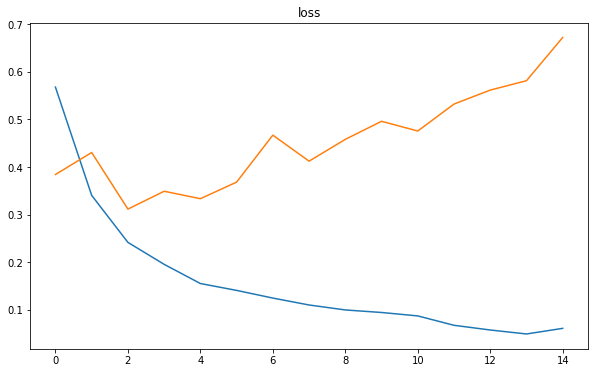

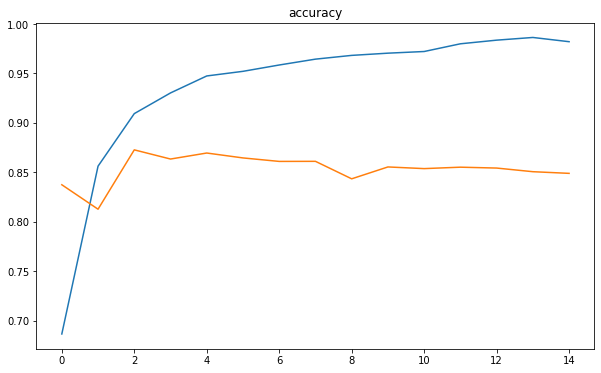

In [24]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                            epochs=15, batch_size=128, validation_data=(X_valid_trim, y_valid))


plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

This time changing only the batch size into 256 in order to see the affect of the batch size in 64 units Bidirectional LSTM

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 128)               38400     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 138,529
Trainable params: 138,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
98/98 [==============================] - 12s 92ms/step - loss: 0.6669 - accuracy: 0.6326 - val_loss: 0.6348 - val_accuracy: 0.7418
Epoch 2/5
98/98 [==============================] - 9s 87ms/step - loss: 0.4120 - accuracy: 0.8274 - val_loss: 0.3774 - val_accuracy: 0.8328
Epoch 3/5
98/98 [==============================] - 9s 87ms/step - loss: 0.2552 - accuracy: 0.899

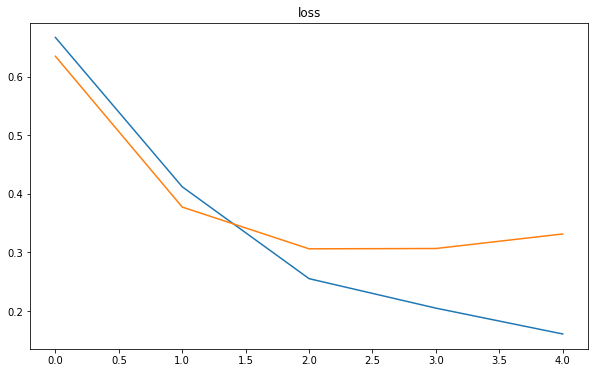

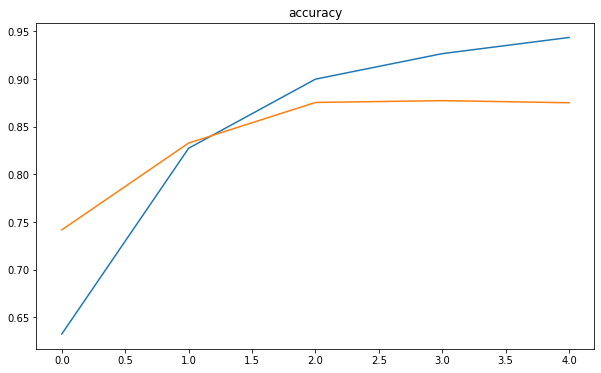

In [25]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                            epochs=5, batch_size=256, validation_data=(X_valid_trim, y_valid))


plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

This time using 8 units with epochs 5:

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 16)                1216      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 101,233
Trainable params: 101,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 14s 59ms/step - loss: 0.5870 - accuracy: 0.6876 - val_loss: 0.4181 - val_accuracy: 0.8299
Epoch 2/5
196/196 [==============================] - 11s 57ms/step - loss: 0.3380 - accuracy: 0.8723 - val_loss: 0.3891 - val_accuracy: 0.8414
Epoch 3/5
196/196 [==============================] - 11s 58ms/step - loss: 0.2674 - accurac

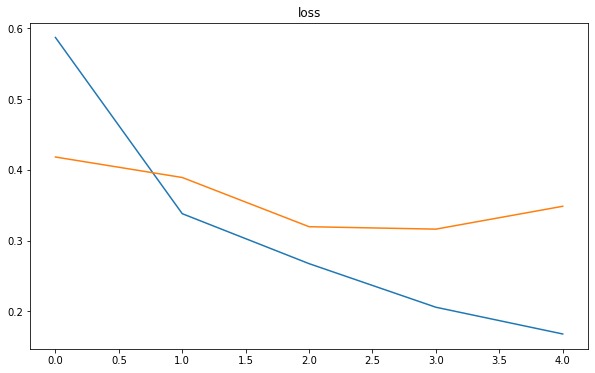

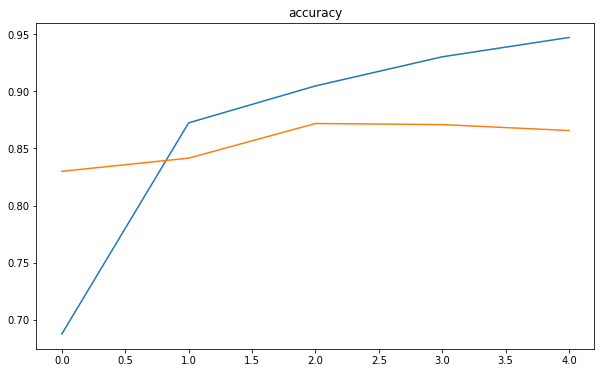

In [26]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(8)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                            epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))


plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

8 units, epoch size increased to 15:

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 16)                1216      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 101,233
Trainable params: 101,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 14s 59ms/step - loss: 0.6138 - accuracy: 0.6952 - val_loss: 0.5210 - val_accuracy: 0.7638
Epoch 2/15
196/196 [==============================] - 11s 57ms/step - loss: 0.4609 - accuracy: 0.8198 - val_loss: 0.3955 - val_accuracy: 0.8488
Epoch 3/15
196/196 [==============================] - 11s 56ms/step - loss: 0.3153 - accu

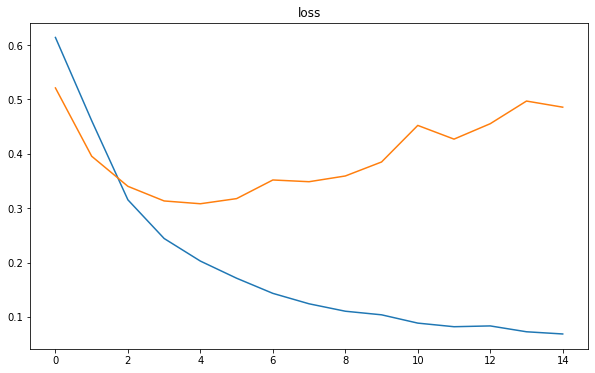

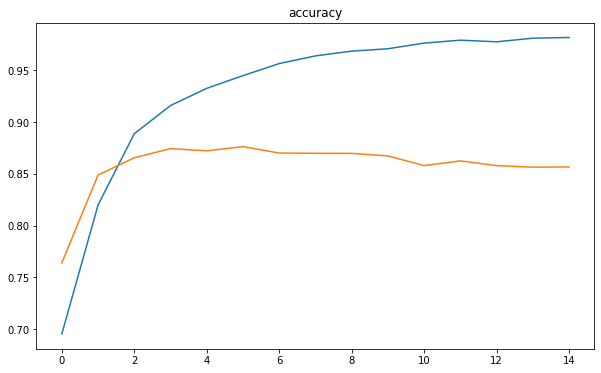

In [27]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(8)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                            epochs=15, batch_size=128, validation_data=(X_valid_trim, y_valid))


plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

8 units with batch size 256:

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 16)                1216      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 101,233
Trainable params: 101,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
98/98 [==============================] - 9s 69ms/step - loss: 0.6780 - accuracy: 0.6104 - val_loss: 0.5821 - val_accuracy: 0.7712
Epoch 2/5
98/98 [==============================] - 6s 64ms/step - loss: 0.4877 - accuracy: 0.7936 - val_loss: 0.4219 - val_accuracy: 0.8281
Epoch 3/5
98/98 [==============================] - 6s 66ms/step - loss: 0.3439 - accuracy: 0.8763

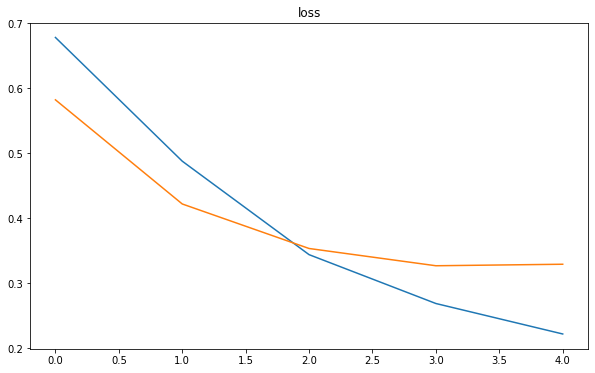

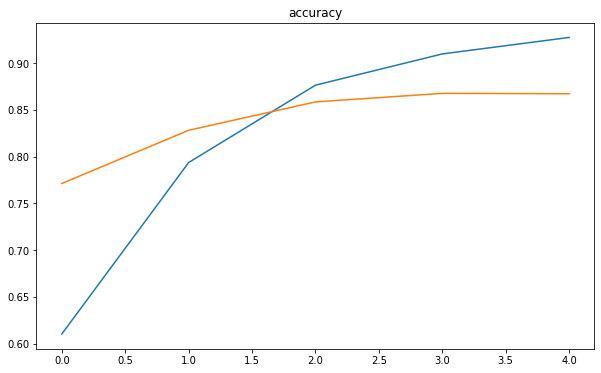

In [28]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(8)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                            epochs=5, batch_size=256, validation_data=(X_valid_trim, y_valid))


plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

# **Summarizing**
I have changed the hyperparameters in the  first bidirectional LSTM model shown without dropout.
The Bidirectional LSTM: accuracy:0.8670 loss: 0.3196

Firstly I have tried it with **32 units:**
Changing the epochs from 5 to 15 : accuracy: 0.8602 loss:0.5239

Changing the batch size from 128 to 256(5 epochs): accuracy: 0.8745 loss: 0.3010

Secondly I have tried it with **64 units:**

Epochs 5 and batch_size =128: accuracy: 0.8618 loss:0.3513

Epochs increased to 15: accuracy: 0.8534 loss:0.6381

Batch size increased to 256(5 epochs): accuracy: 0.8790 loss:0.3155

Thirdly I have used **8 units:**
Epochs 5 and batch_size =128: accuracy: 0.8714 loss:0.3356

Epochs increased to 15: accuracy: 0.8564 loss:0.4847

Batch size increased to 256(5 epochs): accuracy: 0.8790 loss:0.3155


The best accuracy obtained from all the models is the one with 64 units 5 epochs and 256 batch size which is 0.8790.

The best accuracy with epochs=5 and batch_size=128, is obtained with the 8 units model. I think this affect is caused because the other models 32 and 64 units was too complex for the data.

In all the models, increasing the number of epochs to 15 caused overfitting, the losses of all the models increased. Therefore it is clear that the model is memorizing the things, with too many epochs, the best epoch to be used in this case is 5 instead of 15.

In all the models, increasing the number of batch size to 256, helped the models perform better. It increased the accuracy and decreased the loss in all models. Batch size impacts how quickly a model learns and the stability of the learning process, therefore in this case increasing the batch size helped all the models.

Eventhough the result obtained from unit size to 8 outperformed the ones which has an epoch=5 and batch_size=128, 
The best model accuracy was obtained from units=64 epochs=5 and batch_size=256.
Therefore increasing batch size helped all the models, and made also one model to be the best.

